In [153]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix #classification_report, plot_roc_curve, plot_precision_recall_curve 
import pandas as pd
import numpy as np 
from functools import partial
#import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)

from optuna.visualization import plot_optimization_history
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")


# Step 1 - Use all variables

In [161]:
features_df = pd.read_csv("bitcoin_train.csv")
features_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Daily_Change,Daily_Change_Ind,MACD,...,Daily_Change_Perc_Gold,Increased_Gold,RSI_Gold,Close/Last_SP500,Open_SP500,Daily_Change_SP500,Daily_Change_Perc_SP500,Increased_SP500,RSI_SP500,label
0,268,2015-11-30,371.437012,382.363007,370.382996,377.321014,71701600,6.027008,1.0,10.296558,...,0.008807,1,33.968948,2080.41,2090.95,-10.54,-0.005041,0,57.384705,0.0
1,1016,2018-11-15,5736.149902,5774.819824,5358.379883,5648.029785,7032140000,-90.320313,0.0,-121.126607,...,0.002641,1,48.296230,2730.20,2693.52,36.68,0.013618,1,59.599184,0.0
2,1144,2019-05-23,7677.269043,7943.791504,7533.196777,7881.846680,24457107820,201.780274,1.0,625.729133,...,0.009777,1,53.162762,2822.24,2836.70,-14.46,-0.005097,0,41.547984,1.0
3,1082,2019-02-25,3807.002441,3913.707275,3807.002441,3882.696289,9318796067,72.268799,1.0,94.876946,...,-0.001802,0,58.979842,2796.11,2804.35,-8.24,-0.002938,0,45.563129,0.0
4,1149,2019-05-31,8320.286133,8586.659180,8172.550781,8574.501953,25365190957,255.029297,1.0,608.732748,...,0.013842,1,63.288965,2752.06,2766.15,-14.09,-0.005094,0,20.448755,0.0


In [162]:
features_df.columns

feature_lst = ['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5','PROC_10', 'wpr',\
                'sto_os', 'goog_trend_score', 'retweets_count', 'likes_count', \
                'replies_count', 'Daily_Change_Perc', 'Daily_Change_Gold', \
                'Daily_Change_Perc_Gold', 'Increased_Gold', \
                'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'Increased_SP500', \
                'compound_weighted', 'compound_weighted_avg7', \
                'compound_weighted_daily_diff' , 'compound_weighted_weekly_diff',
                'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff',
                'count', 'count_daily_diff', 'count_weekly_diff']

outcome = features_df.columns[-1]

print(feature_lst)
print(outcome)

['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5', 'PROC_10', 'wpr', 'sto_os', 'goog_trend_score', 'retweets_count', 'likes_count', 'replies_count', 'Daily_Change_Perc', 'Daily_Change_Gold', 'Daily_Change_Perc_Gold', 'Increased_Gold', 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'Increased_SP500', 'compound_weighted', 'compound_weighted_avg7', 'compound_weighted_daily_diff', 'compound_weighted_weekly_diff', 'replies_count_daily_diff', 'replies_count_avg7', 'replies_count_weekly_diff', 'count', 'count_daily_diff', 'count_weekly_diff']
label


In [163]:
X = features_df[feature_lst]
y = features_df[outcome]
print(X.shape, y.shape)

(1246, 29) (1246,)


In [164]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

-----------------------------------------------
Trying hyperparameter tuning (OPTUNA):

In [158]:
# USING OPTUNA TO CHOOSE BEST HYPERPARAMETERS
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R",
                                random_state = 1234)


    X = features_df[feature_lst]
    y = features_df[outcome]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)                          
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [159]:
# from optuna.samplers import TPESampler
# sampler2 = TPESampler(seed=10) 
# study = optuna.create_study(direction ='maximize', sampler=optuna.samplers.RandomSampler(seed=123))


In [160]:
# study.optimize((objective), n_trials=20,n_jobs=-1)

# trial = study.best_trial
# print("Best Score: ", trial.value)
# print("Best Params: ")
# for key, value in trial.params.items():
#     print("  {}: {}".format(key, value))

Best Score:  0.5352564102564102
Best Params: 
  max_depth: 4
  n_estimators: 850
  learning_rate: 0.9999999999999999


In [85]:
# run models with hyperparameters from optuna on 
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 200,
                              learning_rate = 0.43, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [86]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.5192307692307693
MSE: 0.4807692307692308
CONFUSION: [[ 56  85]
 [ 65 106]]


In [171]:
# optuna.visualization.plot_param_importances(study)

In [170]:
# plot_optimization_history(study)

end of what Ana suggested

-----------------------------------------------------------------------

run a regular decision tree model with different tree depth, 
use as comparison to show that adaboost is better

In [ ]:
# # Figure out what the tree depth should be (maximum score)
# results_dict = {}
# cx_validation = KFold(n_splits = 10, shuffle = True, random_state = 1)
# for depth in range(1, 11):
#     base_estimator = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
#     if base_estimator.fit(X_train,y_train).tree_.max_depth < depth:
#         break
#     accuracy_score = np.mean(cross_val_score(base_estimator, X, y, cv = cx_validation, scoring = 'accuracy', n_jobs = 1))
#     print("Depth:", depth, ", Score:", accuracy_score)

#     results_dict[depth] = accuracy_score

# max_val = -1
# max_depth_val = None
# for key, val in results_dict.items():
#     if val > max_val:
#         max_val = val
#         max_depth_val = key

# print("Max depth should be:", max_depth_val)   

Straight run of the model with default chosen n_estimators and learning_rate

In [17]:
# # Create adaboost classifer object
# base_estimator = DecisionTreeClassifier(max_depth = 2, random_state = 1234)

# adaboost = AdaBoostClassifier(base_estimator = base_estimator, random_state = 1234)

# # Train Adaboost Classifer
# adaboost.fit(X_train, y_train)

# # Predict the response for valid dataset
# y_hat = adaboost.predict(X_valid)

In [ ]:
# # Model Accuracy with chosen decision tree depth and randomly chosen hyperparameters
# accuracy_score = metrics.accuracy_score(y_valid, y_hat)
# mse = metrics.mean_squared_error(y_valid, y_hat)
# confusion = metrics.confusion_matrix(y_valid, y_hat) 

# print("Accuracy:", accuracy_score)
# print("MSE:", mse)
# print("CONFUSION:", confusion)

In [ ]:
# feature_import = adaboost.feature_importances_
# for i in range(len(feature_lst)):
#     print(f"{feature_lst[i]}: {feature_import[i]}")

hyper parametertuning (number estimators and learning rate)


tuning n_estimators and learning_Rate

In [ ]:
# abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# parameters = {'base_estimator__max_depth':[1,5],
#               'n_estimators':[10,50,500,1000],
#               'learning_rate':[0.01,0.1]}
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)
# grid_result = GridSearchCV(abc, parameters,verbose=3,cv=cv,scoring='accuracy',n_jobs=-1)
# grid_result.fit(X_train,y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # summarize all scores that were evaluated
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# mean_results = []
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
#     mean_results.append(mean)

In [165]:
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# alternative way to check n_estiamtors and learning_Rate
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
# define the grid of values to search
grid = dict()

param_grids  = {'base_estimator__max_depth':[i for i in range(1,2,5)],
              'n_estimators':[10,50,100,500,1000],
              'learning_rate':[0.01,0.1, 1]}


grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)

# define the grid search procedure
#grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_search = GridSearchCV(estimator = model, param_grid = param_grids, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search

grid_result = grid_search.fit(X_train, y_train)
#print("ARE WE HERE")
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.556741 using {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 500}
0.546995 (0.038835) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 10}
0.546633 (0.038238) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 50}
0.553786 (0.035705) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.556696 (0.038027) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 500}
0.553157 (0.040804) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 1000}
0.551293 (0.037687) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 10}
0.555258 (0.040110) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}
0.550278 (0.041876) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 100}
0.556741 (0.042333) with: {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_e

Rerun adaboost with chosen hyperparameters

In [166]:
chosen_depth = list(grid_result.best_params_.values())[0]
chosen_learning_rate = list(grid_result.best_params_.values())[1]
chosen_n = list(grid_result.best_params_.values())[2]
print("chosen_n:", chosen_n)
print("chosen_learning_rate:", chosen_learning_rate)

base_estimator = DecisionTreeClassifier(max_depth = chosen_depth, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 500
chosen_learning_rate: 0.1


In [167]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("CONFUSION:", confusion)

Accuracy: 0.4935897435897436
CONFUSION: [[ 43  98]
 [ 60 111]]


[[ 43  98]
 [ 60 111]]


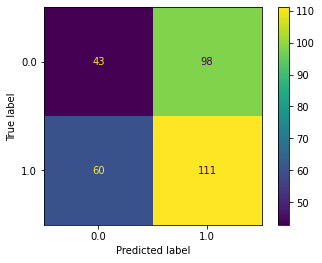

In [169]:
plot_confusion_matrix(adaboost, X_valid, y_valid)
print(metrics.confusion_matrix(y_valid, y_hat))

In [168]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.024
Daily_Change_Ind: 0.0
MACD: 0.098
PROC_3: 0.03
PROC_5: 0.022
PROC_10: 0.054
wpr: 0.038
sto_os: 0.046
goog_trend_score: 0.03
retweets_count: 0.038
likes_count: 0.002
replies_count: 0.028
Daily_Change_Perc: 0.02
Daily_Change_Gold: 0.01
Daily_Change_Perc_Gold: 0.028
Increased_Gold: 0.0
Daily_Change_SP500: 0.032
Daily_Change_Perc_SP500: 0.024
Increased_SP500: 0.0
compound_weighted: 0.042
compound_weighted_avg7: 0.046
compound_weighted_daily_diff: 0.044
compound_weighted_weekly_diff: 0.038
replies_count_daily_diff: 0.05
replies_count_avg7: 0.094
replies_count_weekly_diff: 0.052
count: 0.002
count_daily_diff: 0.038
count_weekly_diff: 0.07


# Repeat for Financial variables

# Repeat for Dogecoin


In [72]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})

In [73]:
X_dog = dogecoin[feature_lst]
y_dog = dogecoin['label']

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X_dog, y_dog, random_state = 1234)

In [75]:
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None, val_rets = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R")
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [76]:
study = optuna.create_study(direction = "maximize")


In [ ]:
study.optimize(objective, n_trials = 20, n_jobs = -1)


trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth = 2, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 250,
                              learning_rate = 0.001, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [ ]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

In [151]:
# Figure out what the tree depth should be (maximum score)
results_dict = {}
cx_validation = KFold(n_splits = 10, shuffle = True, random_state = 1)
for depth in range(1, 11):
    base_estimator = DecisionTreeClassifier(max_depth = depth, random_state = 1234)
    if base_estimator.fit(X_train,y_train).tree_.max_depth < depth:
        break
    accuracy_score = np.mean(cross_val_score(base_estimator, X, y, cv = cx_validation, scoring = 'accuracy', n_jobs = 1))
    print("Depth:", depth, ", Score:", accuracy_score)

    results_dict[depth] = accuracy_score

max_val = -1
max_depth_val = None
for key, val in results_dict.items():
    if val > max_val:
        max_val = val
        max_depth_val = key

print("Max depth should be:", max_depth_val)

Depth: 1 , Score: 0.5232000000000001
Depth: 2 , Score: 0.5119999999999999
Depth: 3 , Score: 0.5176000000000001
Depth: 4 , Score: 0.5216
Depth: 5 , Score: 0.5192
Depth: 6 , Score: 0.5199999999999999
Depth: 7 , Score: 0.5008000000000001
Depth: 8 , Score: 0.5040000000000001
Depth: 9 , Score: 0.5104000000000001
Depth: 10 , Score: 0.4952
Max depth should be: 1


In [152]:
# Create adaboost classifer object
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [153]:
# Model Accuracy with chosen decision tree depth and randomly chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)


Accuracy: 0.7835365853658537
MSE: 0.21646341463414634
CONFUSION: [[239  22]
 [ 49  18]]


In [154]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.1
Daily_Change_Ind: 0.0
MACD: 0.12
PROC_3: 0.04
PROC_5: 0.04
PROC_10: 0.04
wpr: 0.08
sto_os: 0.02
goog_trend_score: 0.12
count: 0.0
compound: 0.02
retweets_count: 0.0
likes_count: 0.04
replies_count: 0.02
compound_weighted_replies: 0.04
compound_weighted_likes: 0.0
compound_weighted_retweets: 0.02
Daily_Change_Perc: 0.02
Daily_Change_Gold: 0.1
Daily_Change_Perc_Gold: 0.1
Increased_Gold: 0.0
Daily_Change_SP500: 0.08
Daily_Change_Perc_SP500: 0.0
Increased_SP500: 0.0


hyper parametertuning (number estimators and learning rate)


In [155]:
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805308 using {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.802584 (0.008477) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.803278 (0.019011) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.802244 (0.008115) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.802261 (0.018886) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.788332 (0.0

Rerun adaboost with chosen hyperparameters

In [156]:
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

chosen_learning_rate = list(grid_result.best_params_.values())[0]
chosen_n = list(grid_result.best_params_.values())[1]

print("chosen_n:", chosen_n)
print("chosen_learing_rate:", chosen_learning_rate)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 10
chosen_learing_rate: 0.001


In [157]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
MSE: 0.20426829268292682
CONFUSION: [[261   0]
 [ 67   0]]


[[261   0]
 [ 67   0]]


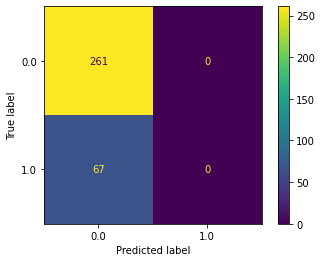

In [158]:
plot_confusion_matrix(adaboost, X_valid, y_valid)
print(metrics.confusion_matrix(y_valid, y_hat))

In [159]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.0
Daily_Change_Ind: 0.0
MACD: 1.0
PROC_3: 0.0
PROC_5: 0.0
PROC_10: 0.0
wpr: 0.0
sto_os: 0.0
goog_trend_score: 0.0
count: 0.0
compound: 0.0
retweets_count: 0.0
likes_count: 0.0
replies_count: 0.0
compound_weighted_replies: 0.0
compound_weighted_likes: 0.0
compound_weighted_retweets: 0.0
Daily_Change_Perc: 0.0
Daily_Change_Gold: 0.0
Daily_Change_Perc_Gold: 0.0
Increased_Gold: 0.0
Daily_Change_SP500: 0.0
Daily_Change_Perc_SP500: 0.0
Increased_SP500: 0.0


-----------------------------------------------------------------
Repeat with fewer attributes
------------------------------------------------------------

first do bitcoin

In [79]:
features_df.columns

features_lst = ['MACD', 'RSI', 'PROC_3', 'Daily_Change_Perc_SP500', 'Daily_Change_Perc_Gold', \
                'compound_weighted_avg7', 'likes_count_daily_diff', 'pos_weighted_avg7',\
                'retweets_count_weekly_diff','goog_trend_score']

outcome = features_df.columns[-1]

print(feature_lst)
print(outcome)

['Daily_Change', 'Daily_Change_Ind', 'MACD', 'PROC_3', 'PROC_5', 'PROC_10', 'wpr', 'sto_os', 'goog_trend_score', 'count', 'retweets_count', 'likes_count', 'replies_count', 'Daily_Change_Perc', 'Daily_Change_Gold', 'Daily_Change_Perc_Gold', 'Increased_Gold', 'Daily_Change_SP500', 'Daily_Change_Perc_SP500', 'Increased_SP500']
label


In [80]:
X = features_df[feature_lst]
y = features_df[outcome]
print(X.shape, y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1234)

(1246, 20) (1246,)


In [81]:
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R")
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [82]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, n_jobs = -1)

trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.5352564102564102
Best Params: 
  max_depth: 3
  n_estimators: 150
  learning_rate: 0.8649999999999999


In [83]:
base_estimator = DecisionTreeClassifier(max_depth = 2, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 250,
                              learning_rate = 0.001, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [84]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.5416666666666666
MSE: 0.4583333333333333
CONFUSION: [[ 62  79]
 [ 64 107]]


In [85]:
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# alternative way to check n_estiamtors and learning_Rate
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
mean_results = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    mean_results.append(mean)

Best: 0.577156 using {'learning_rate': 0.1, 'n_estimators': 100}
0.558270 (0.046790) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.558270 (0.046790) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.558270 (0.046790) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.556486 (0.046447) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.559677 (0.046496) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.558270 (0.046790) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.556128 (0.045798) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.560036 (0.046449) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.563967 (0.049997) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.572886 (0.051213) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.563959 (0.043869) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.569675 (0.049124) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.577156 (0.051566) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.565694 (0.05

In [86]:
# Create adaboost classifer object
base_estimator = DecisionTreeClassifier(max_depth = 2, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, random_state = 1234)
# Train Adaboost Classifer
adaboost.fit(X_train, y_train)
# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [87]:
# Model Accuracy with chosen decision tree depth and chosen hyperparameters
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.47115384615384615
MSE: 0.5288461538461539
CONFUSION: [[53 88]
 [77 94]]


In [88]:
feature_import = adaboost.feature_importances_
for i in range(len(feature_lst)):
    print(f"{feature_lst[i]}: {feature_import[i]}")

Daily_Change: 0.06837026229462262
Daily_Change_Ind: 0.0
MACD: 0.0984933981907369
PROC_3: 0.08124960788836638
PROC_5: 0.05510786728617159
PROC_10: 0.06006722592379675
wpr: 0.044479782083094256
sto_os: 0.04439830938995261
goog_trend_score: 0.07085841939511693
count: 0.037122684239862105
retweets_count: 0.061018737499452774
likes_count: 0.05253288451127324
replies_count: 0.050023428685943665
Daily_Change_Perc: 0.020446008740331485
Daily_Change_Gold: 0.05330507295888297
Daily_Change_Perc_Gold: 0.059561404144577515
Increased_Gold: 0.0
Daily_Change_SP500: 0.07252642244639963
Daily_Change_Perc_SP500: 0.07043848432141858
Increased_SP500: 0.0


# Repeat fewer vars for dogecoin

In [89]:
dogecoin = pd.read_csv("dogecoin_train.csv")
dogecoin = dogecoin.rename(columns={'goog_trend': 'goog_trend_score'})
features_df.columns

features_lst = ['MACD', 'RSI', 'PROC_3', 'Daily_Change_Perc_SP500', 'Daily_Change_Perc_Gold', \
                'compound_weighted_avg7', 'likes_count_daily_diff', 'pos_weighted_avg7',\
                'retweets_count_weekly_diff','goog_trend_score']

outcome = features_df.columns[-1]
X_dog = dogecoin[feature_lst]
y_dog = dogecoin['label']
X_train, X_valid, y_train, y_valid = train_test_split(X_dog, y_dog, random_state = 1234)

In [90]:
def objective(trial:Trial, train = None, labels = None, val = None, val_labels = None, val_rets = None):
    ada_m_depth = trial.suggest_int("max_depth", 1, 5, step = 1)
    ada_n_estimators = trial.suggest_int("n_estimators", 50, 1000, step = 50)
    ada_learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step = .009)

    base_estimator = DecisionTreeClassifier(max_depth = ada_m_depth, random_state = 1234)
    ada_clf = AdaBoostClassifier(base_estimator, 
                                n_estimators = ada_n_estimators,
                                learning_rate = ada_learning_rate,
                                algorithm = "SAMME.R")
    ada_clf.fit(X_train, y_train)
    accuracy = ada_clf.score(X_valid, y_valid)

    return accuracy

In [91]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, n_jobs = -1)


trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))


Best Score:  0.7926829268292683
Best Params: 
  max_depth: 4
  n_estimators: 250
  learning_rate: 0.9099999999999999


In [92]:
base_estimator = DecisionTreeClassifier(max_depth = 2, random_state = 1234)
adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 250,
                              learning_rate = 0.001, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

In [93]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
MSE: 0.20426829268292682
CONFUSION: [[256   5]
 [ 62   5]]


In [94]:
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 1000]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805308 using {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.805308 (0.002443) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.805308 (0.002443) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.802584 (0.008477) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.804291 (0.018565) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.805308 (0.002443) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.802244 (0.008115) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.801580 (0.019279) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.795795 (0.0

In [95]:
base_estimator = DecisionTreeClassifier(max_depth = 1, random_state = 1234)

chosen_learning_rate = list(grid_result.best_params_.values())[0]
chosen_n = list(grid_result.best_params_.values())[1]

print("chosen_n:", chosen_n)
print("chosen_learing_rate:", chosen_learning_rate)

adaboost = AdaBoostClassifier(base_estimator = base_estimator, n_estimators = chosen_n,
                              learning_rate = chosen_learning_rate, random_state = 1234)

# Train Adaboost Classifer
adaboost.fit(X_train, y_train)

# Predict the response for valid dataset
y_hat = adaboost.predict(X_valid)

chosen_n: 10
chosen_learing_rate: 0.001


In [96]:
accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7957317073170732
MSE: 0.20426829268292682
CONFUSION: [[261   0]
 [ 67   0]]


In [ ]:
plot_confusion_matrix(adaboost, X_valid, y_valid)
print(metrics.confusion_matrix(y_valid, y_hat))

--------------------------------------------------------------------
# MISC OTHER CODE NOT USING

-------------------------------------------------------------
We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

In [45]:
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.635 (0.053)


This achieved 63.5% accuracy with default hyperparameters. Now make predictions on new data

In [47]:
model = AdaBoostClassifier()
# fit the model on the whole dataset
model.fit(X_train, y_train)
# make a single prediction
y_hat = model.predict(X_valid)

accuracy_score = metrics.accuracy_score(y_valid, y_hat)
mse = metrics.mean_squared_error(y_valid, y_hat)
confusion = metrics.confusion_matrix(y_valid, y_hat) 

print("Accuracy:", accuracy_score)
print("MSE:", mse)
print("CONFUSION:", confusion)

Accuracy: 0.7070063694267515
MSE: 0.2929936305732484
CONFUSION: [[ 91  45]
 [ 47 131]]


In [53]:
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=1234)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1234),
                   n_estimators=3, random_state=0)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay


In [ ]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # we convert `data` into a NumPy array to avoid a warning raised in scikit-learn
    DecisionBoundaryDisplay.from_estimator(
        tree, X_train.to_numpy(), response_method="predict", cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                    hue=target_column, data=penguins,
                    palette=palette)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

In [ ]:
# hyper parametertuning (number estimators and learning rate)
# ada = AdaBoostClassifier()
# search_grid = {'n_estimators':[500,1000,2000], 'learning_rate':[.001,0.01,.1]}
# search = GridSearchCV(estimator = ada, param_grid = search_grid, scoring = 'accuracy', n_jobs = 1, cv = cx_validation)

#https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# search.fit(X,y)
# search.best_params_
# print(search.best_params_)
# search.best_score_
# print(search.best_score_)
#Out[34]: 0.7425149700598802



# https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# score = np.mean(cross_val_score(ada, X, y, scoring='accuracy', cv = cx_validation, n_jobs = 1))
# score


#https://python-bloggers.com/2019/01/adaboost-classification-in-python/

# AdaBoostClassifier.get_params().keys()